In [1]:
env_data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
paired_data_file = "merged_paired_water_quality_data.txt"
tran_df <- read.delim(paste(env_data_dir, paired_data_file, sep="/"), row.names=1)
print(dim(tran_df))
table(factor(tran_df$WaterColumnPosition))
colnames(tran_df)

[1] 236  66



lower upper 
  175    61 

[1] "Station"                        "OLD_DATE_TIME"                 
 [3] "OldDepth"                       "qPCR.ct"                       
 [5] "CollectionAgency"               "sequencing_ID"                 
 [7] "TrimCount"                      "TotalDepth"                    
 [9] "PctTotalDepth"                  "WaterColumnPosition"           
[11] "cruise_id"                      "SampleDate"                    
[13] "Depth"                          "PHEO"                          
[15] "TN"                             "TP"                            
[17] "CHLA"                           "DOP"                           
[19] "DON"                            "NH4F"                          
[21] "NO2F"                           "NO3F"                          
[23] "PC"                             "PO4F"                          
[25] "DO"                             "PH"                            
[27] "SALINITY"                       "WTEMP"                         
[29] "LinearTime"                     "DayLength"                     
[31] "FallPeak"                       "SpringPeak"                    
[33] "Discharge_Rappahannock.instant" "Discharge_Rappahannock.15"     
[35] "Discharge_Rappahannock.30"      "Discharge_Rappahannock.60"     
[37] "Discharge_Potomac.instant"      "Discharge_Potomac.15"          
[39] "Discharge_Potomac.30"           "Discharge_Potomac.60"          
[41] "Discharge_Susquehanna.instant"  "Discharge_Susquehanna.15"      
[43] "Discharge_Susquehanna.30"       "Discharge_Susquehanna.60"      
[45] "interpolated_CHLA.instant"      "interpolated_CHLA.15"          
[47] "interpolated_CHLA.30"           "interpolated_CHLA.60"          
[49] "measurement_PAR.instant"        "measurement_PAR.15"            
[51] "measurement_PAR.30"             "measurement_PAR.60"            
[53] "WIND_RATIO_BWI.instant"         "WIND_RATIO_BWI.15"             
[55] "WIND_RATIO_BWI.30"              "WIND_RATIO_BWI.60"             
[57] "PRECIP24HR_BWI.instant"         "PRECIP24HR_BWI.15"             
[59] "PRECIP24HR_BWI.30"              "PRECIP24HR_BWI.60"             
[61] "Discharge_Sum.instant"          "Discharge_Sum.15"              
[63] "Discharge_Sum.30"               "Discharge_Sum.60"              
[65] "Latitude"                       "Longitude"

In [2]:
table(tran_df[,'Station'])


 CB2.2  CB3.1  CB3.2 CB3.3C CB4.1C CB4.2C CB4.3C  CB4.4  CB5.1  CB5.2  CB5.3 
    16     10      9     18      3      9     12     16      9      3     18 
 CB5.4  CB6.1  CB6.2  CB6.3  CB6.4  CB7.1  CB7.2  CB7.3  CB7.4 
    18     11     18     17      4     16     13     13      3 

In [3]:
active_all = c("Station", "SampleDate", "WaterColumnPosition", "cruise_id", "PHEO", "TN", "TP", "CHLA", "DOP",
               "DON", "NH4F", "NO2F", "NO3F", "PC", "PO4F", "DO", "PH", "SALINITY", "WTEMP", "LinearTime", 
               "DayLength", "FallPeak", 'Discharge_Sum.15', 'Latitude')

all_df <- tran_df[,active_all]
all_df[,'Station'] = factor(all_df[,'Station'], ordered=T)
all_df[,'cruise_id'] = factor(all_df[,'cruise_id'], ordered=T)
all_df[,'WaterColumnPosition'] = factor(all_df[,'WaterColumnPosition'], ordered=T)
all_df$SampleDate <- as.POSIXlt(all_df$SampleDate)
all_df$NO3F[all_df$NO3F < 0] = NA
all_df$DOP[all_df$DOP < 0] = NA


In [9]:
library(missMDA)
nb <- estim_ncpPCA(data.matrix(all_df),ncp.min=0,ncp.max=5,method.cv="Kfold",nbsim=50)
imputed <- imputePCA(data.matrix(all_df),ncp=nb$ncp)

impute_counter = 0
for (c in colnames(all_df)) { 
    for (r in rownames(all_df)) { 
        checkval = all_df[r,c]; 
        if (is.na(checkval)){ 
            impute_counter = impute_counter + 1
            all_df[r,c] = imputed$completeObs[r,c]; 
        }
    }
}
message(paste(impute_counter, dim(all_df)[1]*dim(all_df)[2]))


  |======================================================================| 100%


43 5664



In [10]:
subtran = tran_df[which(tran_df$WaterColumnPosition == 'lower'),c('DO', 'WTEMP', 'FallPeak', 'measurement_PAR.60')]
colSums(is.na(subtran))
cor(subtran[which(!is.na(subtran$DO)),])

cor(all_df[,c("SALINITY", 'Latitude', 'NO3F')])

cor(tran_df[which(!is.na(tran_df$SALINITY)),c('measurement_PAR.60', 'SALINITY', 'NO2F', 'NH4F')])

cor(tran_df[which((tran_df$WaterColumnPosition == 'lower') & (!is.na(tran_df$SALINITY))) , 
            c('measurement_PAR.60', 'SALINITY', 'NO2F', 'NH4F')])


DO              WTEMP           FallPeak measurement_PAR.60 
                 3                  0                  0                  0

,DO,WTEMP,FallPeak,measurement_PAR.60
DO,1.0000000,-0.4626368,-0.4182855,-0.4655479
WTEMP,-0.4626368,1.0000000,0.9141321,0.8701008
FallPeak,-0.4182855,0.9141321,1.0000000,0.9145879
measurement_PAR.60,-0.4655479,0.8701008,0.9145879,1.0000000


,SALINITY,Latitude,NO3F
SALINITY,1.0000000,-0.7189719,-0.6334407
Latitude,-0.7189719,1.0000000,0.5187223
NO3F,-0.6334407,0.5187223,1.0000000


,measurement_PAR.60,SALINITY,NO2F,NH4F
measurement_PAR.60,1.000000000,0.12108501,0.33624397,0.001185787
SALINITY,0.121085007,1.00000000,-0.13947391,-0.091100824
NO2F,0.336243970,-0.13947391,1.00000000,-0.038468253
NH4F,0.001185787,-0.09110082,-0.03846825,1.000000000


,measurement_PAR.60,SALINITY,NO2F,NH4F
measurement_PAR.60,1.00000000,0.1439111,0.3716424,-0.07078772
SALINITY,0.14391105,1.0000000,-0.2237119,-0.29336719
NO2F,0.37164236,-0.2237119,1.0000000,-0.18867582
NH4F,-0.07078772,-0.2933672,-0.1886758,1.00000000


In [11]:
library(MASS)
library(nortest)
log_cols = c("PHEO", "TN", "TP", "CHLA", "DOP", "DON", "NH4F", "NO2F", "NO3F", "PC", "PO4F",
             "DO", "PH", "SALINITY", "WTEMP", 'Discharge_Sum.15')

txfms = list()
for (lc in log_cols){
    col_x = all_df[,lc]
    col_x = col_x[!is.na(col_x)] 
    neg_count = sum(col_x < 0)
    if (neg_count > 0){
        col_x = col_x + abs(min(col_x)) + 0.0001
    }
    if (sum(col_x == 0) > 0){
        col_x = col_x + 0.0001
    }

    pval_b4 = ad.test(col_x)$p.value
    pval_aft1 = ad.test(log(col_x + 1))$p.value    
    bc <- boxcox(col_x ~ 1, lambda = seq(-2, 2, 1/100), plotit=F)
    lambda <- bc$x[which.max(bc$y)]
    if (lambda == 0)
        lambda = 1
    if (lambda > 0)
        col_x_bc = col_x^(lambda)
    if (lambda < 0)
        col_x_bc = ((col_x^(lambda))*-1) + min(((col_x^(lambda))*-1))*-1.1
    
    pval_aft2 = ad.test(col_x_bc)$p.value
    if (pval_b4 < pval_aft2) {
        txfms[lc] = lambda
    } else {
        txfms[lc] = 1
    }
    print(paste(c(lc, neg_count, pval_b4, pval_aft1, pval_aft2, txfms[lc]), collapse=", "))
    flush.console()
}


[1] "PHEO, 0, 3.7e-24, 5.88464849136751e-10, 0.000611383063447827, -0.0800000000000001"
[1] "TN, 0, 4.13290244688002e-20, 8.21332379742281e-12, 0.0209952154600329, -0.3"
[1] "TP, 0, 1.63967035297486e-22, 3.41756519140102e-21, 0.000261540434267695, -0.11"
[1] "CHLA, 0, 3.7e-24, 0.000773268029925158, 0.0568132551309008, -0.01"
[1] "DOP, 0, 3.7e-24, 5.18107969594574e-24, 1.7570408683959e-05, -0.03"
[1] "DON, 0, 8.81508458748466e-06, 7.74310682469073e-05, 0.00319793228143199, 0.0100000000000002"
[1] "NH4F, 0, 3.7e-24, 3.7e-24, 2.21544074291052e-16, 0.16"
[1] "NO2F, 0, 3.7e-24, 3.7e-24, 1.72904456897348e-05, -0.0800000000000001"
[1] "NO3F, 11, 3.7e-24, 3.7e-24, 3.7e-24, 1"
[1] "PC, 0, 3.7e-24, 2.40403282074832e-12, 0.303969463525665, -0.28"
[1] "PO4F, 0, 3.7e-24, 3.7e-24, 1.40500452887074e-10, 0.11"
[1] "DO, 0, 1.15131579876551e-06, 9.65798855551094e-20, 1.79116051579519e-08, 1"
[1] "PH, 0, 1.43231801315283e-08, 7.93017820878712e-09, 4.73491033006977e-09, 1"
[1] "SALINITY, 0, 5.226932717047

In [12]:
external_data = c("Station", "SampleDate", "WaterColumnPosition", "cruise_id", "LinearTime","DayLength", 
                  "FallPeak", 'Discharge_Sum.15')

wc_cols = setdiff(active_all, external_data)
wc_df <- all_df[,wc_cols]
for (col_x in names(txfms)){
    if (col_x %in% colnames(wc_df))
        if (txfms[[col_x]] > 0){
            wc_df[,col_x] = wc_df[,col_x]^txfms[[col_x]]
        } else {
            wc_df[,col_x] = ((wc_df[,col_x]^txfms[[col_x]])*-1) + min(((wc_df[,col_x]^txfms[[col_x]])*-1))*-1.1
        }
}
wc_df = scale(wc_df)
colSums(is.na(wc_df))

PHEO       TN       TP     CHLA      DOP      DON     NH4F     NO2F 
       0        0        0        0        0        0        0        0 
    NO3F       PC     PO4F       DO       PH SALINITY    WTEMP Latitude 
       0        0        0        0        0        0        0        0

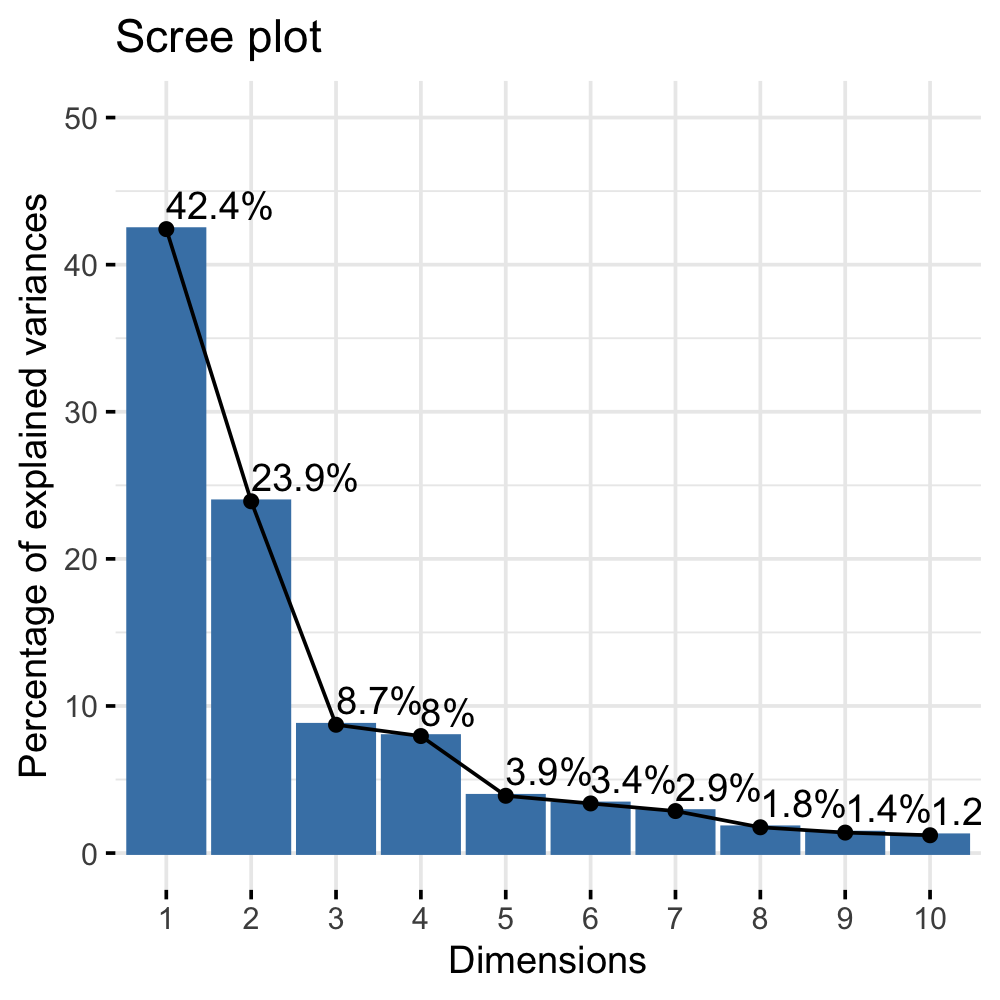

In [13]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=250)
library(FactoMineR)
library(factoextra)
res.pca <- PCA(wc_df, graph = FALSE)
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))

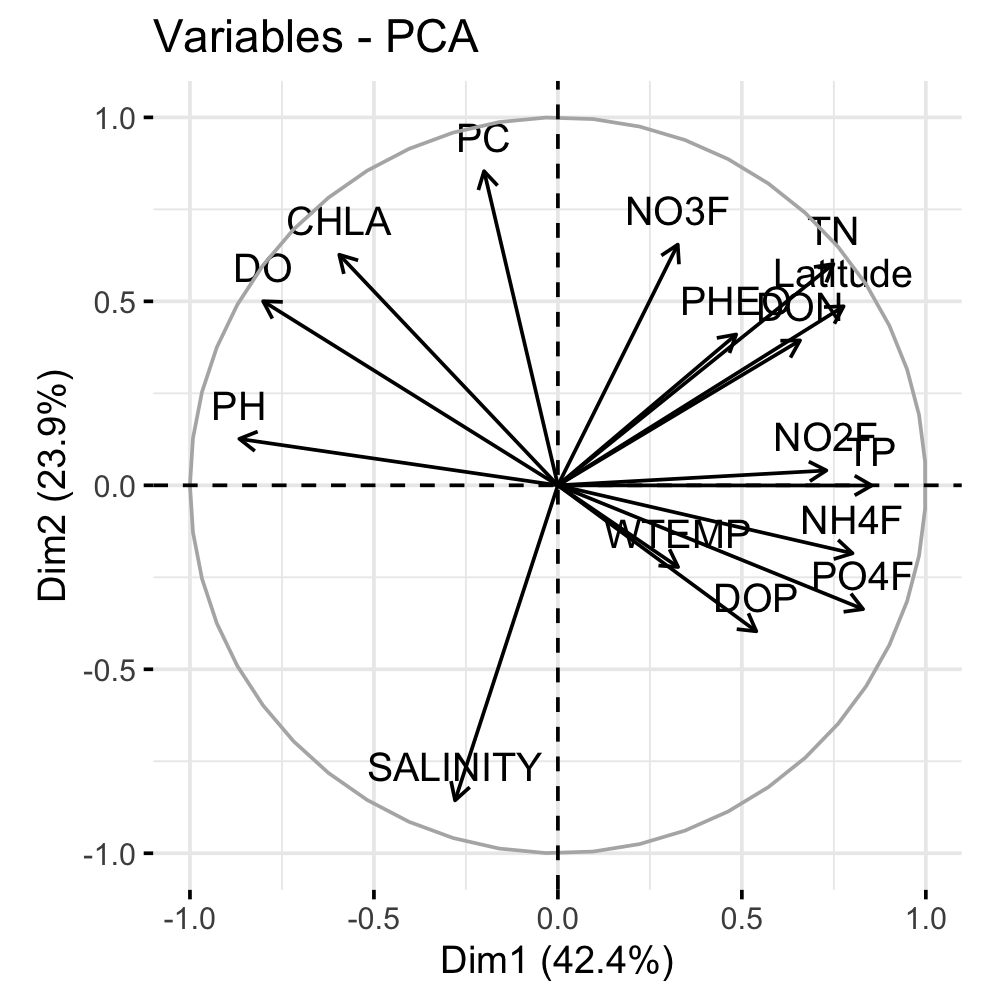

In [14]:
fviz_pca_var(res.pca, axes = c(1, 2), col.var = "black")

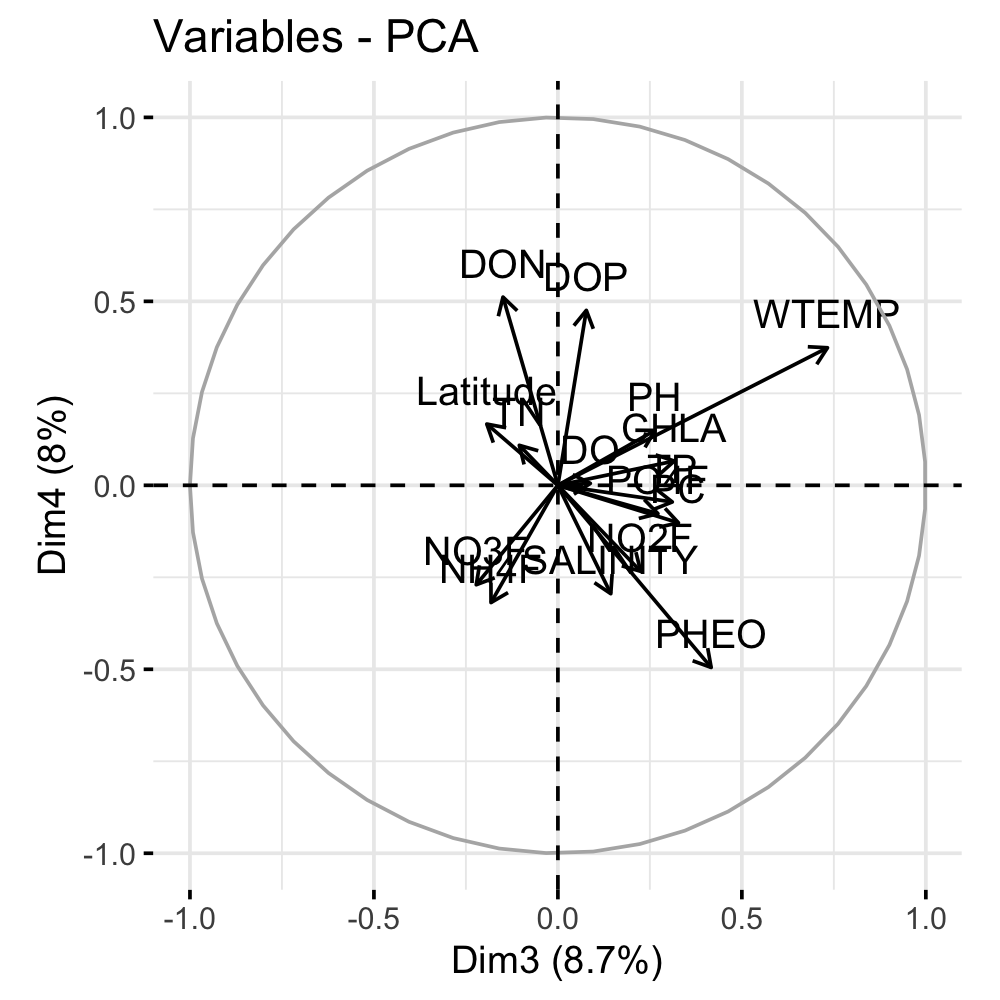

In [15]:
fviz_pca_var(res.pca, axes = c(3, 4), col.var = "black")


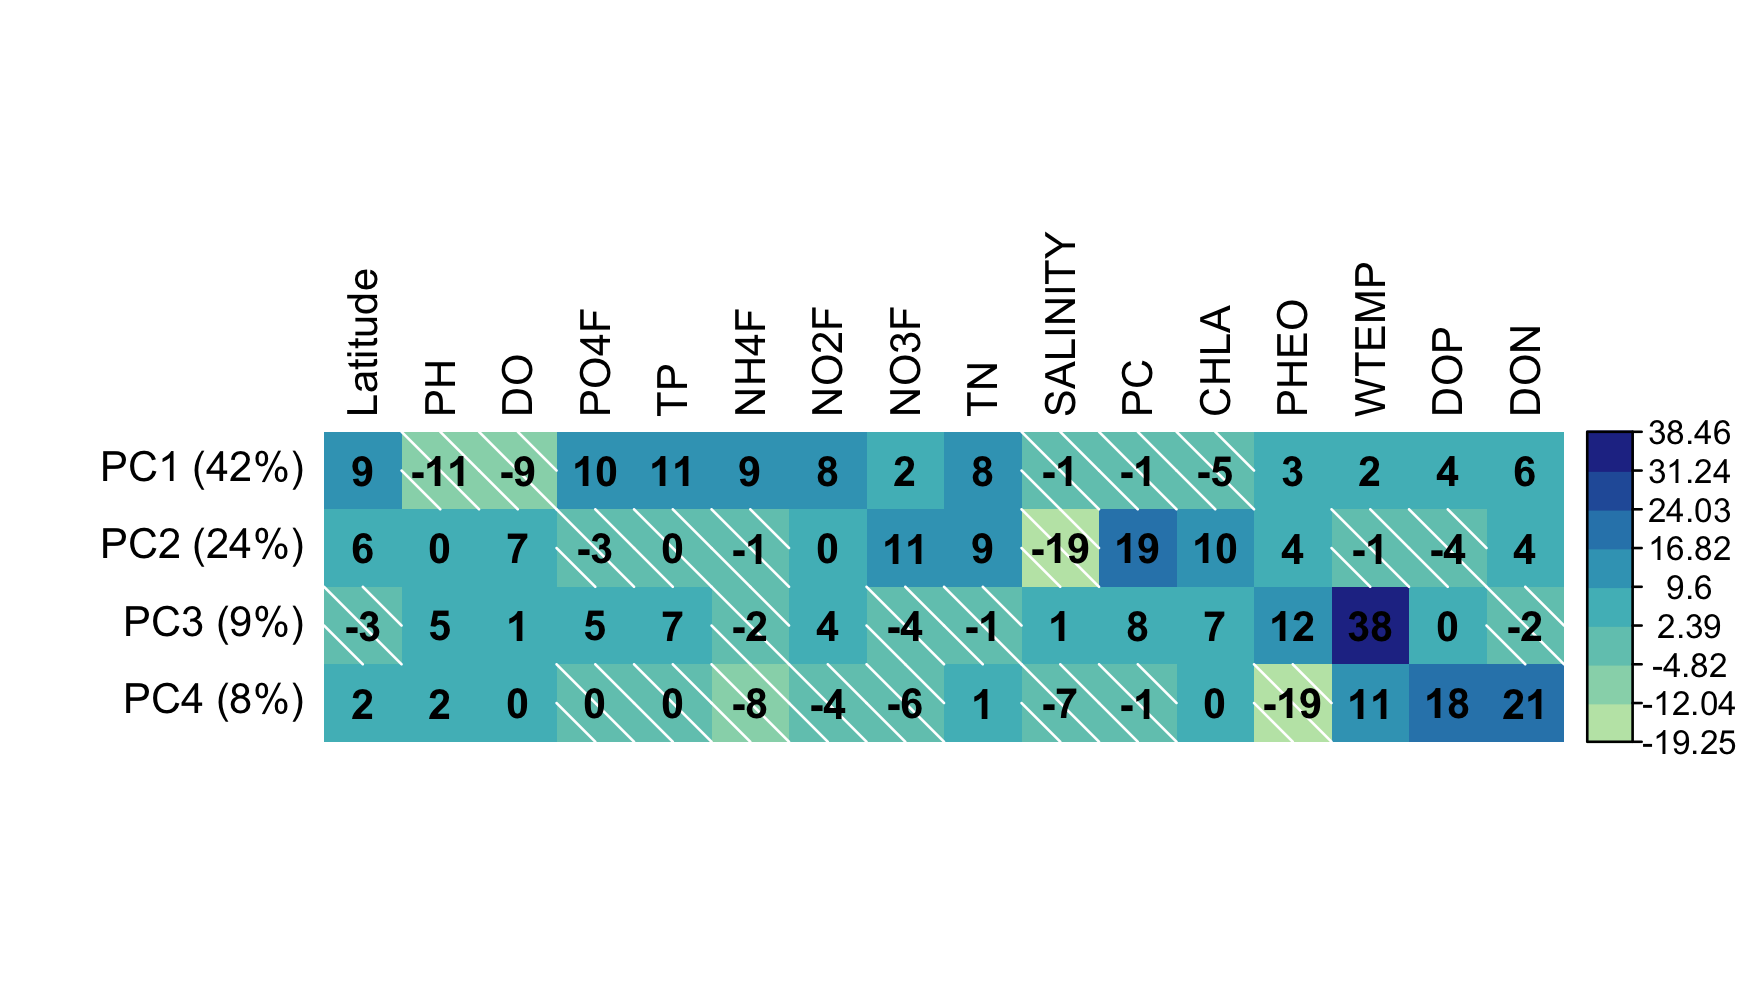

In [16]:
library(corrplot)
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=250)

var <- get_pca_var(res.pca)
coord_plot = t(var$coord)
coord_plot[coord_plot > 0] = 1
coord_plot[coord_plot < 0 ] = -1
contrib_plot = t(var$contrib)

signed_coords = contrib_plot*coord_plot

rownames(signed_coords) <- paste("PC", 1:5, " (", round(res.pca$eig[1:5, 'percentage of variance']), "%)", sep="")

signed_coords = signed_coords[1:4,c('Latitude', 'PH', 'DO', 'PO4F', 'TP', 'NH4F', 'NO2F', 'NO3F', 'TN',
                                 'SALINITY', 'PC', 'CHLA', 'PHEO', 'WTEMP', 'DOP', 'DON')]

corrplot(signed_coords, method='shade', is.corr=FALSE, addCoef.col='black', tl.col = "black", number.digits=0,
         col=colorRampPalette(c("#FFFFCC","#C7E9B4","#7FCDBB","#40B6C4","#2C7FB8" ,"#253494"))(10))


*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


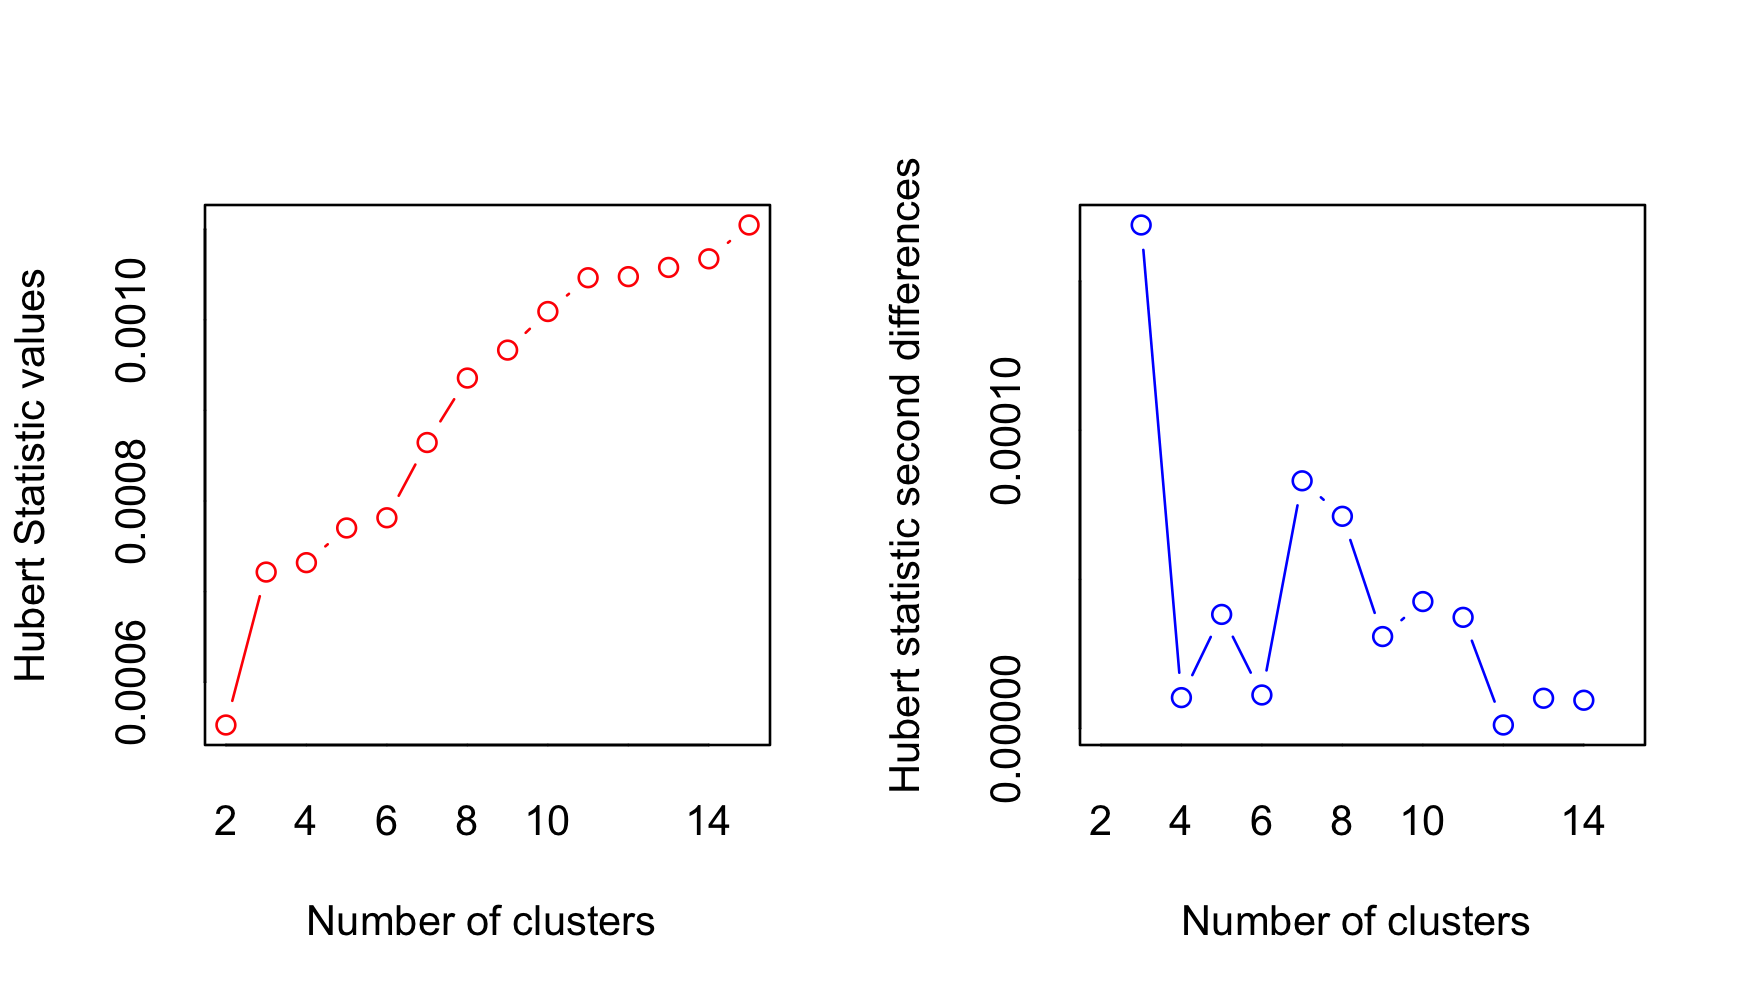

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 4 proposed 2 as the best number of clusters 
* 7 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 2 proposed 6 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 
* 2 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
**************************

[1] "Hartigan"   "TrCovW"     "TraceW"     "Friedman"   "Ratkowsky" 
[6] "Ball"       "PtBiserial"

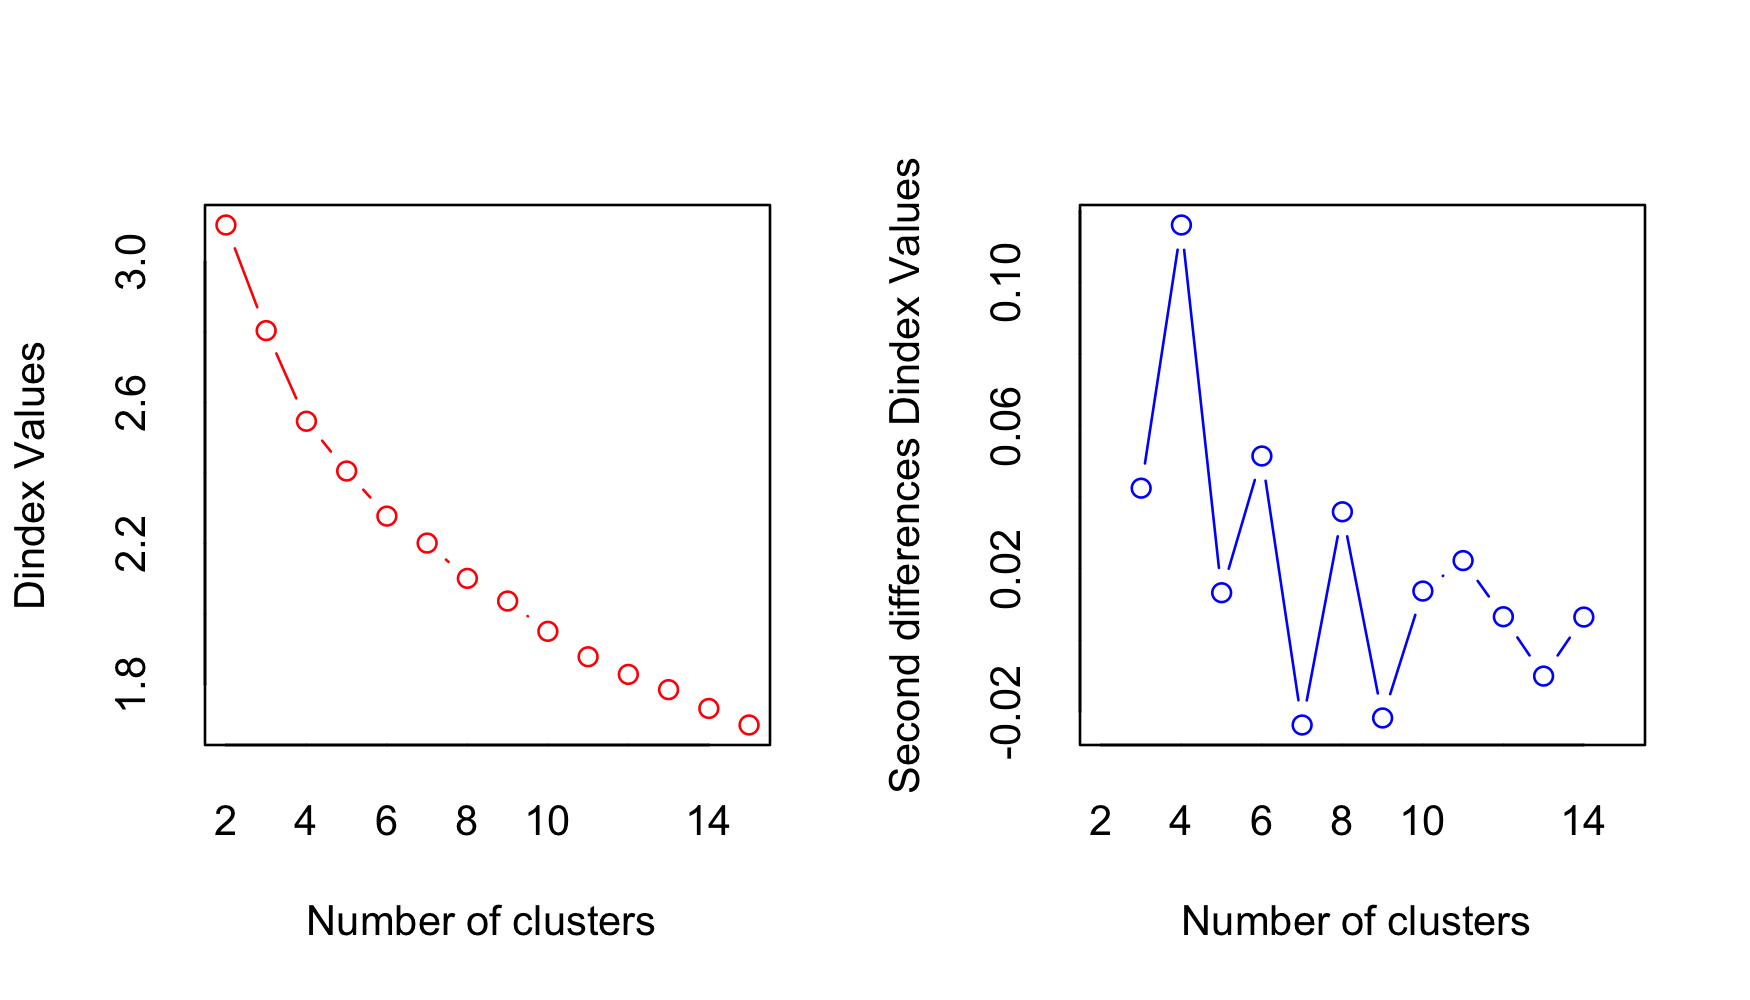

In [17]:
library(NbClust)
wc_df_sc <- scale(wc_df)
number <- NbClust(wc_df_sc, distance="euclidean", min.nc=2, max.nc=15, method='ward.D2', index='all')
colnames(number[['Best.nc']])[which(number[['Best.nc']]['Number_clusters',]  == 3.)]


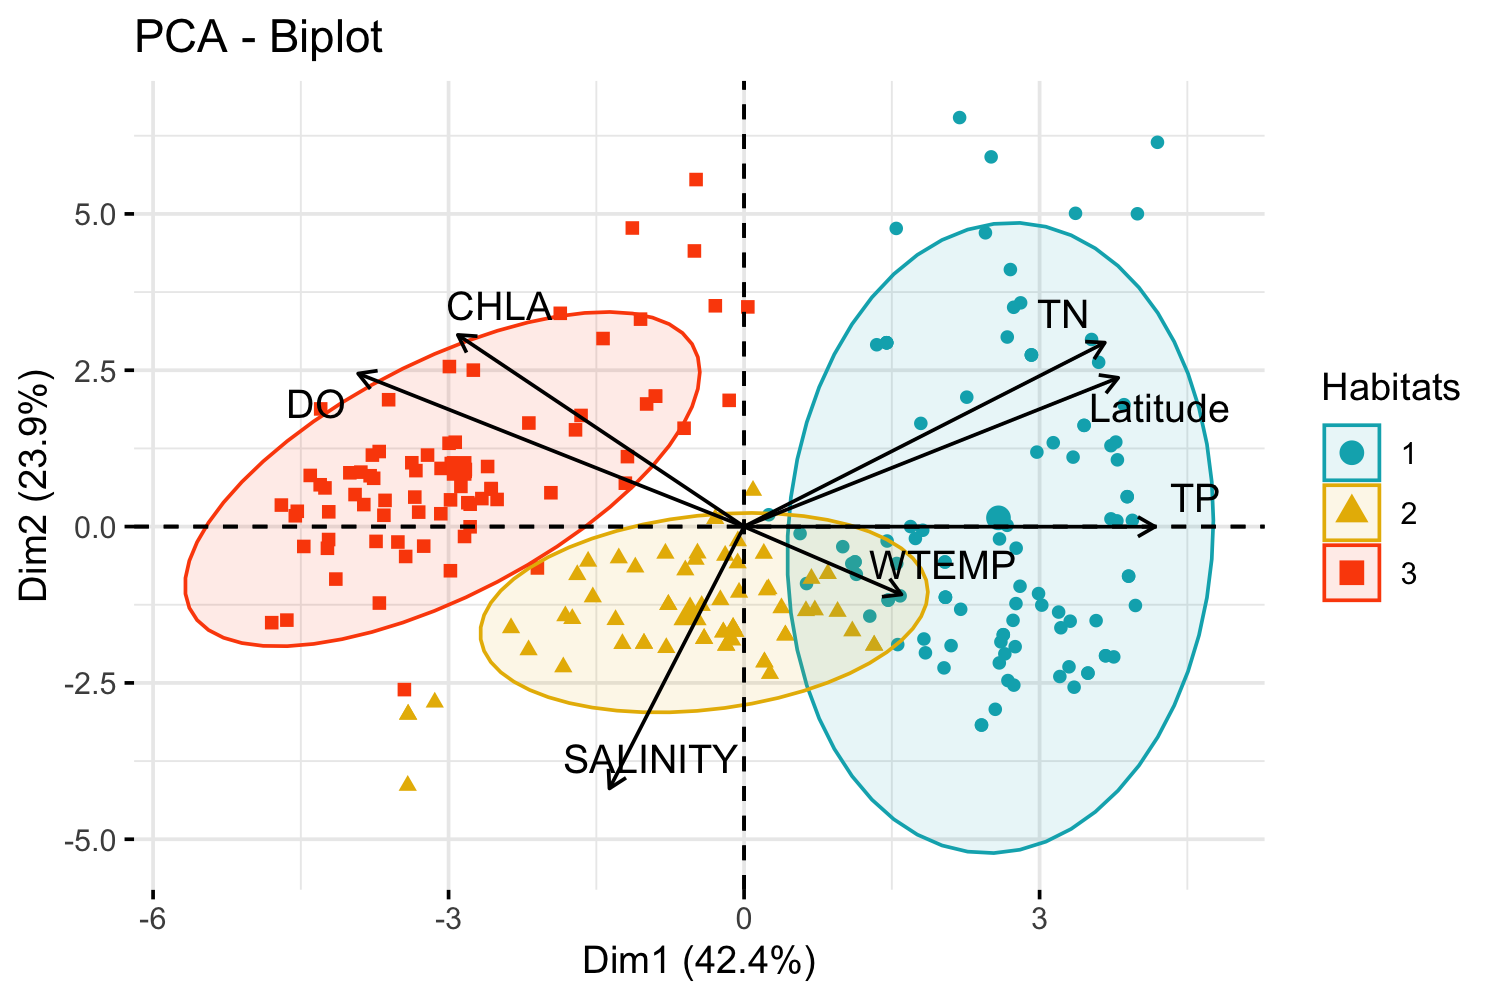

In [18]:
library(cluster)
pam.res <- pam(wc_df_sc, 3, diss=FALSE, metric='euclidean')
options(repr.plot.width=6, repr.plot.height=4)
fviz_pca_biplot(res.pca,
                geom.ind = "point", # show points only (nbut not "text")
                col.ind = as.factor(pam.res$clustering), # color by groups
                palette = c("#00AFBB", "#E7B800", "#FC4E07"),
                addEllipses = TRUE, ellipse.type = "t",# Concentration ellipses
                legend.title = "Habitats",
                select.var = list(name = c('CHLA', 'WTEMP', 'SALINITY', 'TP', 'TN', 'DO', 'Latitude')),
                repel = TRUE, col.var = "black")

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


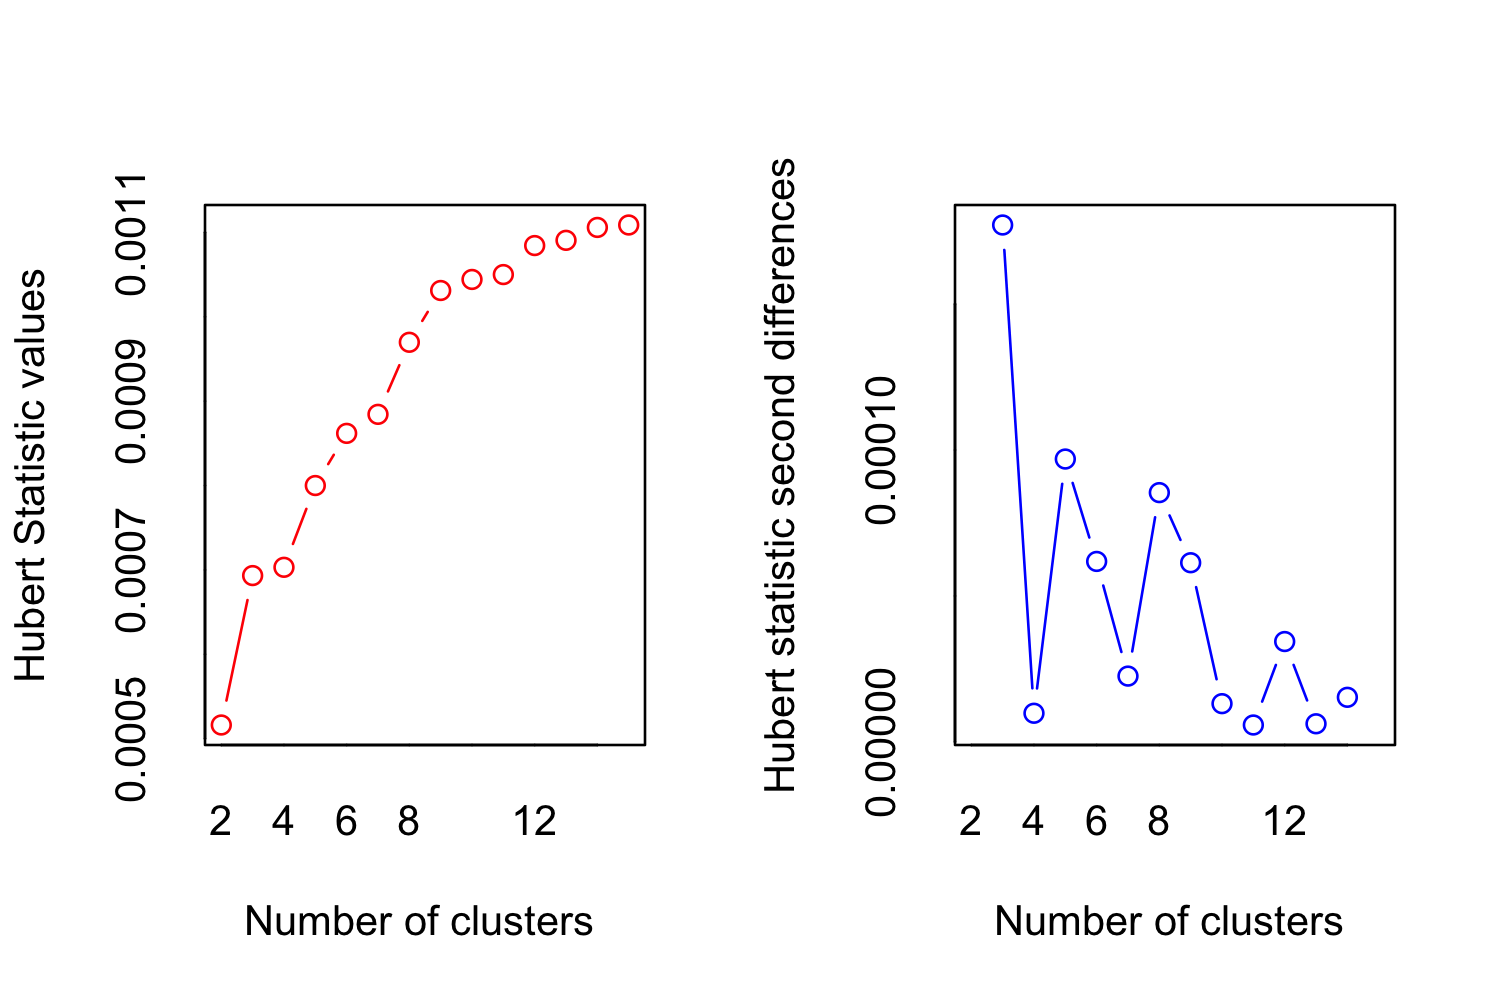

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 3 proposed 2 as the best number of clusters 
* 13 proposed 3 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 
* 1 proposed 10 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 
* 2 proposed 12 as the best number of clusters 
* 2 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
******************************************************************* 


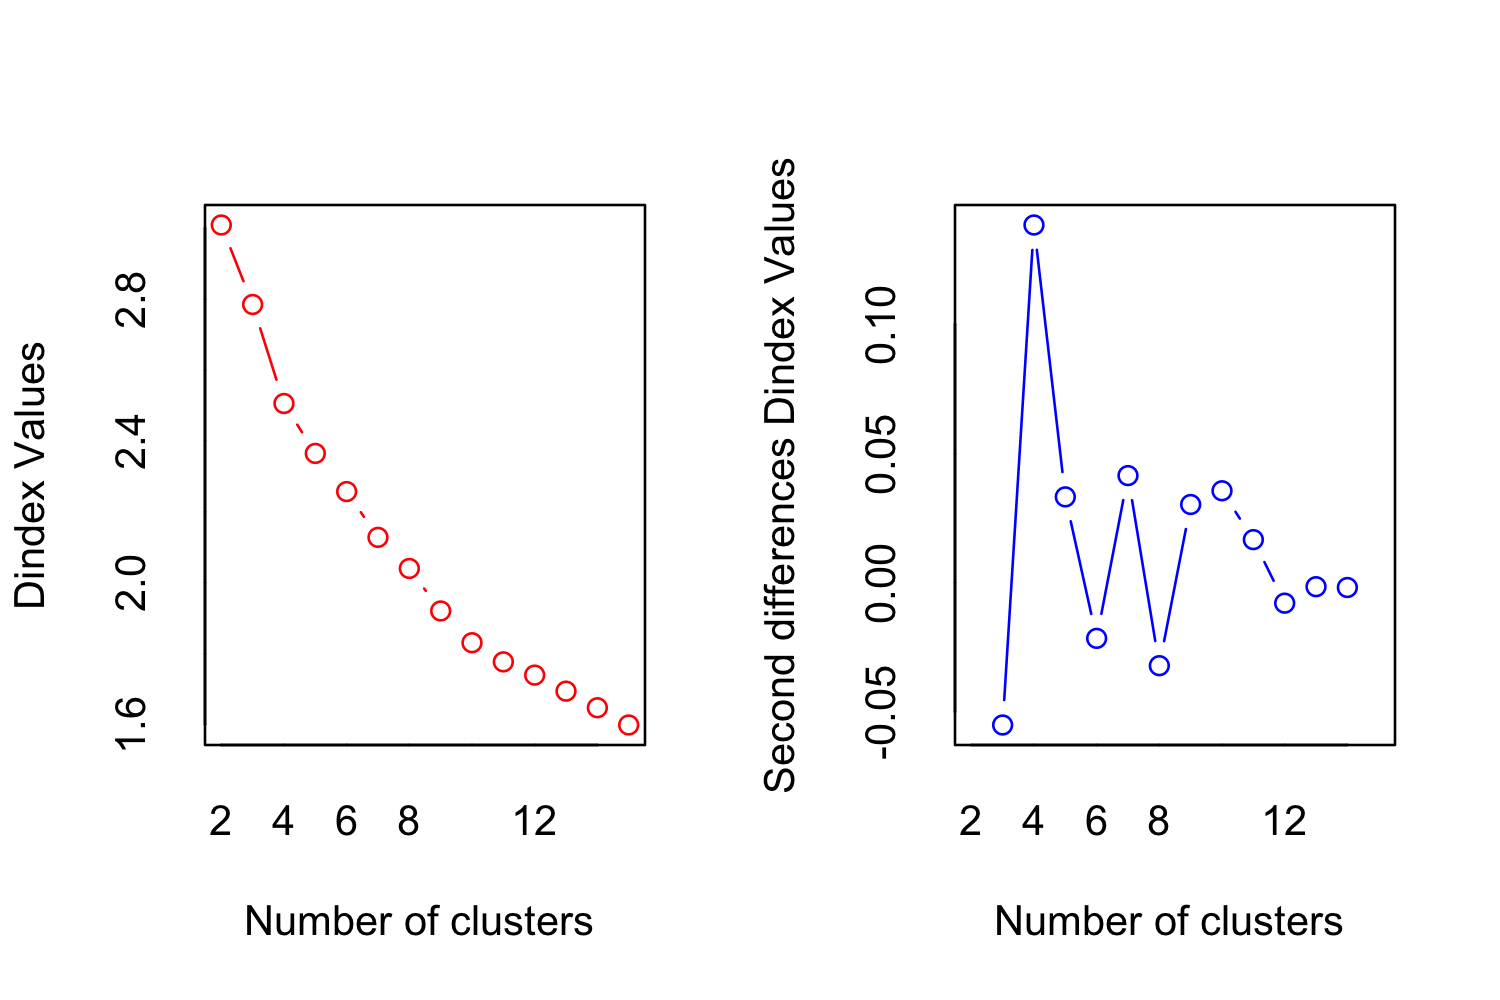

   
     1  2  3
  1 94  3  2
  2  0 59  1
  3  0  2 75

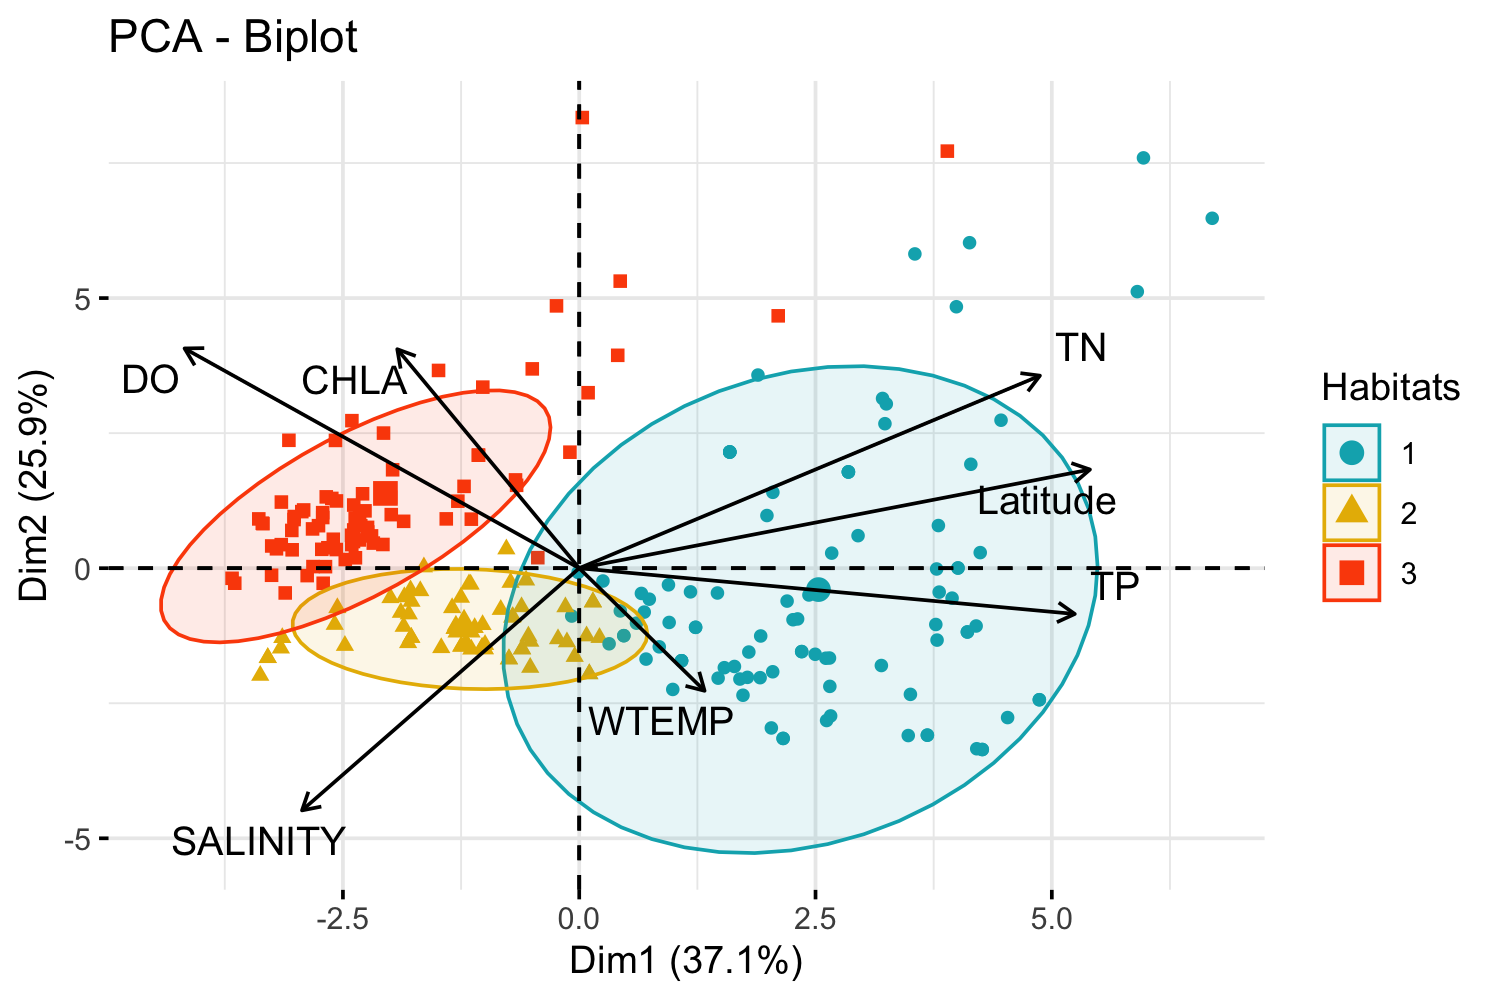

In [19]:
wc_df_nt = scale(all_df[,colnames(wc_df)])
number2 <- NbClust(wc_df_nt, distance="euclidean", min.nc=2, max.nc=15, method='ward.D2', index='all')
pam.res2 <- pam(wc_df_nt, 3, diss=FALSE, metric='euclidean')
fviz_pca_biplot(PCA(wc_df_nt, graph=F),
                geom.ind = "point", # show points only (nbut not "text") 
                col.ind = as.factor(pam.res2$clustering), # color by groups
                palette = c("#00AFBB", "#E7B800", "#FC4E07"),
                addEllipses = TRUE, ellipse.type = "t",# Concentration ellipses
                legend.title = "Habitats",
                select.var = list(name = c('CHLA', 'WTEMP', 'SALINITY', 'TP', 'TN', 'DO', 'Latitude')),
                repel = TRUE, col.var = "black")
table(pam.res$clustering, pam.res2$clustering)

In [20]:
meta_env = cbind(all_df)
colnames(meta_env)[colnames(meta_env) == 'FallPeak'] = 'Season'
colnames(meta_env)[colnames(meta_env) == 'PO4F'] = 'PO4'
colnames(meta_env)[colnames(meta_env) == 'SALINITY'] = 'Salinity'
meta_env = scale(meta_env[,c('DayLength', 'Season', 'PO4', 'Salinity')])


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7



PC1       PC2       PC3   Habitat DayLength    Season       PO4  Salinity 
"numeric" "numeric" "numeric"  "factor" "numeric" "numeric" "numeric" "numeric"

,PC1,PC2
,<dbl>,<dbl>
Season,-0.3825714,-0.2976096
PO4,-0.7215410,-0.3127681
Salinity,0.2830889,-0.8640153


,PC1,PC2,PC3,Season,Hab,Sal
PC1,1.000,0.000,0.000,-0.383,0.883,0.283
PC2,0.000,1.000,0.000,-0.298,0.208,-0.864
PC3,0.000,0.000,1.000,-0.715,-0.109,-0.135
Season,-0.383,-0.298,-0.715,1.000,-0.309,0.158
Hab,0.883,0.208,-0.109,-0.309,1.000,0.069
Sal,0.283,-0.864,-0.135,0.158,0.069,1.000


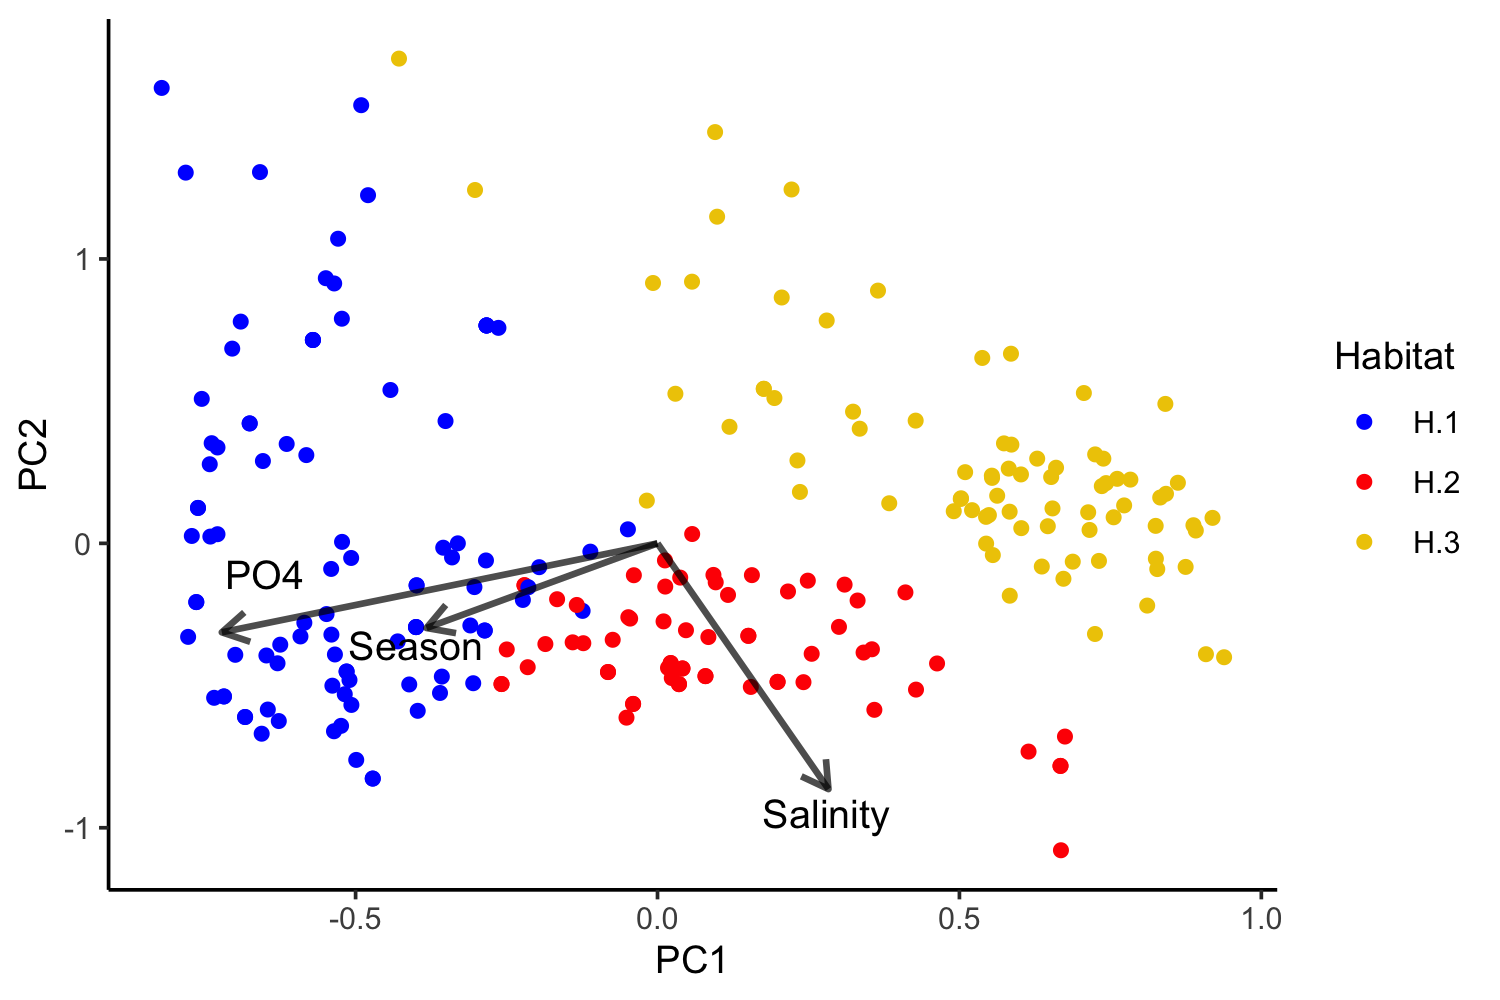

In [21]:
library(ggplot2)
library(vegan)

my.rda <- rda(wc_df_sc, scale=T)
rdaxy = scores(my.rda, display="sites", choice=1:3)
fit.swUF = envfit(my.rda, subset(meta_env, select=(-DayLength)))
cluster.types = data.frame('Habitat'=factor(paste("H", pam.res2$clustering, sep="."), levels=c('H.1','H.2','H.3')) )
plot.df.mini = cbind.data.frame(rdaxy, cluster.types, meta_env)

sapply(plot.df.mini, class)

spp.scrs <- as.data.frame(scores(fit.swUF, display = "vectors"))
#spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*0.5})
spp.scrs

options(repr.plot.width=6, repr.plot.height=4)
sp2<-ggplot(plot.df.mini, aes(x=PC1, y=PC2)) + geom_point(aes(color=Habitat)) + theme_classic() + 
              scale_color_manual(values = c("H.3" = "gold2", "H.2" = "red1", "H.1" = "blue")) +
              annotate("segment", x = 0, xend = spp.scrs[,'PC1'],y = 0, yend = spp.scrs[,'PC2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
              annotate('text', x= c(-0.4, -0.65, 0.28), 
                               y= c(-0.36, -0.11, -0.95), 
                               label=c('Season', 'PO4', 'Salinity'),
                               color='black', alpha=1.0, size=4)
sp2

#+ theme(legend.text=element_text(size=X)) + theme(axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))

cordf = cbind(plot.df.mini$PC1, plot.df.mini$PC2, plot.df.mini$PC3, plot.df.mini$Season, as.integer(plot.df.mini$Habitat),
              plot.df.mini$Salinity)
colnames(cordf) <- c("PC1", 'PC2', 'PC3', 'Season', 'Hab', 'Sal')
round(cor(cordf), 3)

In [22]:
# extract the classification
n_clusts = length(unique(pam.res$clustering))
habitat = as.data.frame(pam.res$clustering)
habitat2 = as.data.frame(pam.res2$clustering)
table(habitat)
colnames(habitat) <- 'HABITAT'
colnames(habitat2) <- 'HABITAT.2'
habitat$HABITAT <- factor(habitat$HABITAT)

# add a few more variables of interest
active_tran_plus = c(wc_cols, 'FallPeak', 'WaterColumnPosition')
tran_active_plus =  all_df[rownames(habitat), active_tran_plus]

table(tran_active_plus$WaterColumnPosition, habitat$HABITAT)
table(tran_active_plus$WaterColumnPosition, habitat2$HABITAT.2)

tran_active_plus$WaterColumnPosition = as.numeric(as.integer(tran_active_plus$WaterColumnPosition))

mean_cols = vector(length=n_clusts); iqr_cols = vector(length=n_clusts)
for (i in 1:n_clusts){
    mean_cols[[i]] = paste(as.character(i), "Mean", sep = "-")
    iqr_cols[[i]] = paste(as.character(i), "Std", sep = "-")
    }

clust_med = aggregate(x=tran_active_plus, by=habitat2, FUN=mean)
print(mean_cols)
print(dim(clust_med))
rownames(clust_med) <- mean_cols

clust_sd = aggregate(x=tran_active_plus, by=habitat2, FUN=IQR)
print(iqr_cols)
rownames(clust_sd) <- iqr_cols

clust_data = rbind(clust_med, clust_sd)

clust_data[,1] <- NULL
clust_data_t = as.data.frame(t(clust_data))
rownames(clust_data_t)[rownames(clust_data_t) == 'FallPeak'] = 'Seasonality'
row_select_order = c('WaterColumnPosition', "TN", 'CHLA', 'DON', 'NO3F', 'DO', 'PH', 'WTEMP', 
                     'SALINITY', 'Latitude')
tbl_to_print = round(clust_data_t[row_select_order, c(1,4,2,5,3,6)], 2)
tbl_to_print[c(1), c(1)] = round((0/99)*100, 2)
tbl_to_print[c(1), c(3)] = round((0/60)*100, 2)
tbl_to_print[c(1), c(5)] = round((61/(61 + 17))*100, 2)

tbl_to_print2 <- data.frame(lapply(tbl_to_print, as.character), stringsAsFactors=FALSE)

tbl_to_print2['Group.1'] = paste(tbl_to_print2[,c(1)], tbl_to_print2[,c(2)], sep="±")
tbl_to_print2['Group.2'] = paste(tbl_to_print2[,c(3)], tbl_to_print2[,c(4)], sep="±")
tbl_to_print2['Group.3'] = paste(tbl_to_print2[,c(5)], tbl_to_print2[,c(6)], sep="±")

#data <- within(data,  id <- paste(F, E, D, C, sep=""))
tbl_to_print3 = tbl_to_print2[,c('Group.1', 'Group.2', 'Group.3')]
rownames(tbl_to_print3) <- rownames(tbl_to_print)
tbl_to_print3
#write.table(tbl_to_print3, sep="\t", file=paste(env_data_dir, 'habitat_summary_table1.txt', sep="/"))

habitat
 1  2  3 
99 60 77 

       
         1  2  3
  lower 98 59 18
  upper  1  1 59

       
         1  2  3
  lower 94 64 17
  upper  0  0 61

[1] "1-Mean" "2-Mean" "3-Mean"
[1]  3 19
[1] "1-Std" "2-Std" "3-Std"


,Group.1,Group.2,Group.3
,<chr>,<chr>,<chr>
WaterColumnPosition,0±0,0±0,78.21±0
TN,0.67±0.19,0.36±0.08,0.44±0.17
CHLA,2.17±1.9,2.62±1.3,7.75±3.72
DON,0.31±0.06,0.18±0.04,0.22±0.03
NO3F,0.08±0.09,0±0,0.04±0.01
DO,2.39±3.26,4.53±1.52,8.5±1.51
PH,7.35±0.2,7.77±0.18,8.14±0.18
WTEMP,23.32±4.2,24.31±2.46,20.11±12.66
SALINITY,16.01±9.03,24.59±3.5,16.6±5.19


In [23]:
colnames(all_df)

[1] "Station"             "SampleDate"          "WaterColumnPosition"
 [4] "cruise_id"           "PHEO"                "TN"                 
 [7] "TP"                  "CHLA"                "DOP"                
[10] "DON"                 "NH4F"                "NO2F"               
[13] "NO3F"                "PC"                  "PO4F"               
[16] "DO"                  "PH"                  "SALINITY"           
[19] "WTEMP"               "LinearTime"          "DayLength"          
[22] "FallPeak"            "Discharge_Sum.15"    "Latitude"

In [25]:
metadata_full = cbind.data.frame(all_df, habitat2)

fit <- aov(HABITAT.2 ~ DO + TN + TP + Latitude + WTEMP + SALINITY + NO3F + CHLA + DON + PH + FallPeak, data=metadata_full)
metadata_full[, 'HABITAT.2'] <- as.factor(metadata_full[, 'HABITAT.2'])
summary(fit)
fit2 <- aov(DO ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit2, which='HABITAT.2')

fit3 <- aov(TN ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit3, which='HABITAT.2')

fit4 <- aov(SALINITY ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit4, which='HABITAT.2')

fit5 <- aov(CHLA ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit5, which='HABITAT.2')

fit5 <- aov(PH ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit5, which='HABITAT.2')

fit5 <- aov(Latitude ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit5, which='HABITAT.2')

fit5 <- aov(WTEMP ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit5, which='HABITAT.2')

fit5 <- aov(FallPeak ~ HABITAT.2, data=metadata_full)
TukeyHSD(fit5, which='HABITAT.2')

metadata_fuller = cbind.data.frame(all_df, habitat2)
env_data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
hab_fname = "Transformed_WQ_Vars_and_Habitats_Final.txt"
hab_file = paste(env_data_dir, hab_fname, sep="/")
write.table(metadata_fuller, file=hab_file, sep="\t")

             Df Sum Sq Mean Sq  F value   Pr(>F)    
DO            1 119.97  119.97 1317.995  < 2e-16 ***
TN            1  16.62   16.62  182.580  < 2e-16 ***
TP            1   0.09    0.09    1.032  0.31083    
Latitude      1   0.65    0.65    7.166  0.00798 ** 
WTEMP         1   0.03    0.03    0.288  0.59196    
SALINITY      1   3.38    3.38   37.080 4.88e-09 ***
NO3F          1   0.00    0.00    0.003  0.95764    
CHLA          1   5.75    5.75   63.196 9.13e-14 ***
DON           1   0.50    0.50    5.496  0.01993 *  
PH            1   3.42    3.42   37.581 3.92e-09 ***
FallPeak      1   0.11    0.11    1.217  0.27108    
Residuals   224  20.39    0.09                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = DO ~ HABITAT.2, data = metadata_full)

$HABITAT.2
        diff      lwr      upr p adj
2-1 2.144713 1.516751 2.772676     0
3-1 6.111256 5.517768 6.704745     0
3-2 3.966543 3.313012 4.620074     0


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = TN ~ HABITAT.2, data = metadata_full)

$HABITAT.2
           diff          lwr        upr   p adj
2-1 -0.31722361 -0.390376027 -0.2440712 0.00000
3-1 -0.23394856 -0.303085009 -0.1648121 0.00000
3-2  0.08327505  0.007144148  0.1594059 0.02819


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SALINITY ~ HABITAT.2, data = metadata_full)

$HABITAT.2
          diff       lwr       upr     p adj
2-1  8.5754041  6.647042 10.503766 0.0000000
3-1  0.5839036 -1.238594  2.406401 0.7304669
3-2 -7.9915005 -9.998378 -5.984623 0.0000000


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = CHLA ~ HABITAT.2, data = metadata_full)

$HABITAT.2
         diff        lwr      upr     p adj
2-1 0.4530452 -0.7571399 1.663230 0.6515457
3-1 5.5883778  4.4446303 6.732125 0.0000000
3-2 5.1353326  3.8758736 6.394792 0.0000000


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = PH ~ HABITAT.2, data = metadata_full)

$HABITAT.2
         diff       lwr       upr p adj
2-1 0.4261132 0.3589994 0.4932270     0
3-1 0.7960563 0.7326270 0.8594857     0
3-2 0.3699431 0.3000967 0.4397895     0


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Latitude ~ HABITAT.2, data = metadata_full)

$HABITAT.2
          diff        lwr        upr     p adj
2-1 -1.2600403 -1.4334211 -1.0866594 0.0000000
3-1 -0.9737082 -1.1375707 -0.8098458 0.0000000
3-2  0.2863320  0.1058918  0.4667722 0.0006684


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = WTEMP ~ HABITAT.2, data = metadata_full)

$HABITAT.2
          diff        lwr       upr     p adj
2-1  0.9936933 -0.8797919  2.867178 0.4244316
3-1 -3.2071007 -4.9777340 -1.436467 0.0000834
3-2 -4.2007940 -6.1505601 -2.251028 0.0000023


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = FallPeak ~ HABITAT.2, data = metadata_full)

$HABITAT.2
          diff        lwr        upr     p adj
2-1  0.1296121 -0.1062074  0.3654316 0.3986000
3-1 -0.5056720 -0.7285454 -0.2827987 0.0000006
3-2 -0.6352841 -0.8807053 -0.3898630 0.0000000


In [ ]:
wc_tx_plus_hab = cbind.data.frame(wc_df[rownames(habitat),], habitat, habitat2)
env_data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
hab_fname = "Transformed_WQ_Vars_and_Habitats.txt"
hab_file = paste(env_data_dir, hab_fname, sep="/")
write.table(wc_tx_plus_hab, file=hab_file, sep="\t")

In [ ]:
d = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
f1 = paste(env_data_dir, "Transformed_WQVars_Hab_and_aDiv.txt", sep="/")
f2 = paste(env_data_dir, "Transformed_WQ_Vars_and_Habitats.txt", sep="/")
df2 <- read.delim(f2, row.names=1)[,'HABITAT.2']
f3 = paste(env_data_dir, "merged_paired_water_quality_data.txt", sep="/")
df3 <- cbind.data.frame(read.delim(f1, row.names=1), df2)
colnames(df3)[colnames(df3) == 'df2'] = 'HABITAT.2'
env_data_orig <- read.delim(f3, row.names=1)

extra_cols1 = c('ENSpie.1', 'FaithsPD.1', 'Observed.ASVs.1', 'Chao1', 'ACE',  'Observed.ASVs', 'qPCR.ct', 
                'Discharge_Susquehanna.15', 'SpringPeak', 'Station', 'ENSpie')

df4 = df3[,colnames(df3)[which(!(colnames(df3) %in% extra_cols1))]]

df4$Microbial.Clusters <- factor(df4$Microbial.Clusters)
df4$WaterColumnPosition <- factor(df4$WaterColumnPosition)
intcols = colnames(df4)[which(sapply(df4, class) == 'integer')]
for (ic in intcols)
    df4[,ic] = factor(df4[,ic])

df4[,'Habitat'] <- NULL
names(df4)[names(df4) == 'HABITAT.2'] = 'Habitat'


In [ ]:
predictors = res.pca$ind$coord
pred_resp = cbind(predictors, data.frame('Microbial.Clusters' = df4$Microbial.Clusters))

library(xgboost)
library(caret)

set.seed(100)  # For reproducibility
# Create index for testing and training data
inTrain <- createDataPartition(y = pred_resp$Microbial.Clusters, p = 0.75, list = FALSE)
# subset power_plant data to training
training <- pred_resp[inTrain,]
# subset the rest to test
testing <- pred_resp[-inTrain,]

X_train = xgb.DMatrix(as.matrix(training[,colnames(predictors)]))
y_train = training$Microbial.Clusters
X_test = xgb.DMatrix(as.matrix(testing[,colnames(predictors)]))
y_test = testing$Microbial.Clusters
dim(X_test)
length(y_test)
dim(X_train)
length(y_train)

xgb_trcontrol = trainControl(method = "cv", number = 5)

tune_grid <- expand.grid(nrounds = seq(from = 100, to = 300, by = 50),
                         eta = c(0.025, 0.01, 0.005, 0.015, 0.02),
                         max_depth = c(2, 3, 4, 5, 6),
                         gamma = 0,
                         colsample_bytree = 1,
                         min_child_weight = 1,
                         subsample = 1)
dim(tune_grid)
set.seed(0) 
xgb_model = train(
  X_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = tune_grid,
  method = "xgbTree")
xgb_model

xgb_pred = predict(xgb_model, newdata=X_test)
confusionMatrix(table(xgb_pred, y_test))


In [ ]:
xgb_model$bestTune


In [ ]:
full_X <- xgb.DMatrix(as.matrix(pred_resp[,colnames(predictors)]))
full_y <- pred_resp$Microbial.Clusters
xgb_trcontrol2 = trainControl(method = "repeatedcv", number = 5, repeats=5)
tune_grid2 <- expand.grid(nrounds = 260,
                         eta = 0.01,
                         max_depth = 4,
                         gamma = 0,
                         colsample_bytree = 1,
                         min_child_weight = 1,
                         subsample = 1)


xgb_model_f = train(full_X, full_y,  
                    trControl = xgb_trcontrol2,
                    tuneGrid = tune_grid2,
                    method = "xgbTree")
xgb_model_f
xgb_unknown_hab = predict(xgb_model_f, newdata=full_X)
confusionMatrix(table(xgb_unknown_hab, full_y))


In [ ]:
fviz_pca_biplot(res.pca, axes = c(2, 3),
                geom.ind = "point", # show points only (nbut not "text")
                col.ind = all_df[,'WTEMP'],
                #palette = c("#00AFBB", "#E7B800", "#FC4E07"),
                gradient.cols = c("#00AFBB", "#FC4E07"),
                #addEllipses = T,
                select.var = list(name = c('CHLA', 'WTEMP', 'SALINITY', 'TP', 'TN', 'DO', 'Latitude')),
                repel = TRUE, col.var = "black")


In [ ]:
library(GGally)

wc_plus = cbind.data.frame(wc_df[rownames(habitat),], 
                           all_df[rownames(habitat), c('FallPeak', 'WaterColumnPosition', 'DayLength')],
                           habitat)

wc_plus[,'TP'] <- NULL
wc_plus[,'PC'] <- NULL
wc_plus[,'PHEO'] <- NULL

names(wc_plus)[names(wc_plus) == 'FallPeak'] <- 'Seasonality'
names(wc_plus)[names(wc_plus) == 'HABITAT'] <- 'Habitat'
names(wc_plus)[names(wc_plus) == 'NO2F'] <- 'NO2'
names(wc_plus)[names(wc_plus) == 'NO3F'] <- 'NO3'
names(wc_plus)[names(wc_plus) == 'NH4F'] <- 'NH4'
names(wc_plus)[names(wc_plus) == 'WaterColumnPosition'] <- 'Surface/Bottom'
names(wc_plus)[names(wc_plus) == 'PO4F'] <- 'PO4'
names(wc_plus)[names(wc_plus) == 'SALINITY'] <- 'Salinity'

# Convert data to numeric
corr_wc <- data.frame(lapply(wc_plus, as.double))
clust_cols = hclust(dist(t(corr_wc)), method = "complete")
#clust_cols = hclust(as.dist(cor(corr_wc)), method = "ward.D2")
label_order = rev(clust_cols$labels[clust_cols$order])
# Plot the graph
options(repr.plot.width=7, repr.plot.height=7)
ggcorr(corr_wc[,label_order], method = c("pairwise", "spearman"), nbreaks = 6,
       hjust = 0.9, size=3.6, label = TRUE, label_size = 3.3, color = "black", layout.exp=2.)

png(filename="/Volumes/KeithSSD/ChesapeakeMicrobiome/figures/water_chem_correlations.png")
ggcorr(corr_wc[,label_order], method = c("pairwise", "spearman"), nbreaks = 6,
       hjust = 0.9, size=3.6, label = TRUE, label_size = 3.3, color = "black", layout.exp=2)
dev.off()

In [ ]:
library(GGally)

predictor_sets1 = c('Latitude', 'SALINITY', 'NH4F', 'DO', 'PO4F', 'NO3F', 'NO2F', 'WTEMP', 'DayLength', 
                    'FallPeak', 'Discharge_Sum.15', 'measurement_PAR.60', 'measurement_PAR.instant', 'CHLA')
wc_plusx = tran_df[,predictor_sets1]

names(wc_plusx)[names(wc_plusx) == 'FallPeak'] <- 'Seasonality'
names(wc_plusx)[names(wc_plusx) == 'NO2F'] <- 'NO2'
names(wc_plusx)[names(wc_plusx) == 'NO3F'] <- 'NO3'
names(wc_plusx)[names(wc_plusx) == 'NH4F'] <- 'NH4'
names(wc_plusx)[names(wc_plusx) == 'PO4F'] <- 'PO4'
names(wc_plusx)[names(wc_plusx) == 'measurement_PAR.60'] <- 'PAR.60'
names(wc_plusx)[names(wc_plusx) == 'measurement_PAR.instant'] <- 'PAR.daily'
names(wc_plusx)[names(wc_plusx) == 'Discharge_Sum.15'] <- 'Discharge.15'
wc_plusx = wc_plusx[which(complete.cases(wc_plusx)),]

# Convert data to numeric
#corr_wc <- data.frame(lapply(wc_plusx, as.double))
#clust_cols = hclust(dist(t(corr_wc)), method = "complete")
#label_order = rev(clust_cols$labels[clust_cols$order])
# Plot the graph
#options(repr.plot.width=7, repr.plot.height=7)
#ggcorr(corr_wc[,label_order], method = c("pairwise", "pearson"), nbreaks = 6,
#       hjust = 0.9, size=3.6, label = TRUE, label_size = 3.3, color = "black", layout.exp=1.)

plot(wc_plus$CHLA, wc_plus$DO)

In [ ]:
wcpcs = res.pca$ind$coord[,c('Dim.2')]
habitat = pam.res$clustering
active_all = c('WTEMP', 'SALINITY', 'DO', 'PH', "Latitude", 'Depth_Percentage')
test_rows <- setdiff(rownames(all_df), names(habitat))
print(c(length(test_rows), length(rownames(all_df)), length(names(habitat))))
test_dataset <- all_df[test_rows, active_all]
all_in_tran = all_df[names(habitat), active_all] 

simple_dataset = cbind(all_in_tran, factor(habitat), wcpcs)
colnames(simple_dataset) <- c(active_all, 'HABITAT', 'PrinComp2')

print(str(simple_dataset))
print(str(test_dataset))

col

In [ ]:
max(xgb_model_f$results$Accuracy)

In [ ]:
set.seed(2) 

y_train = training$PrinComp2
y_test = testing$PrinComp2

xgb_model2 = train(X_train, y_train, trControl = xgb_trcontrol, tuneGrid = xgbGrid,
                  method = "xgbTree")

xgb_pred2 = predict(xgb_model2, newdata=X_test)
plot(xgb_pred2, y_test)
postResample(pred = xgb_pred2, obs = y_test)
full_X <- xgb.DMatrix(as.matrix(simple_dataset[,colnames(test_dataset)]))
full_y <- simple_dataset$PrinComp2

xgb_model_f2 = train(
  full_X, full_y,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree")

xgb_model_f2$bestTune
max(xgb_model_f2$results$Rsquared)

xgb_unknown_PR2 = predict(xgb_model_f2, newdata=unknown_X)


In [ ]:
names(xgb_unknown_hab) <- rownames(test_dataset)
names(xgb_unknown_PR2) <- rownames(test_dataset)

In [ ]:
ad_out = "../otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
all_df[,'habitat'] <- NA
all_df[rownames(simple_dataset),'habitat'] <- simple_dataset[,'HABITAT']
all_df[names(xgb_unknown_hab),'habitat'] <- xgb_unknown_hab

all_df[,'AC_PrinComp2'] <- NA
all_df[rownames(simple_dataset),'AC_PrinComp2'] <- simple_dataset[,'PrinComp2']
all_df[names(xgb_unknown_PR2),'AC_PrinComp2'] <- xgb_unknown_PR2

colSums(is.na(all_df[,c('habitat', 'AC_PrinComp2')]))

write.table(x = all_df,  file = ad_out, sep = '\t')


In [ ]:
trcontrol = trainControl(
  method = "cv",
  number = 5,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
tunegrid <- expand.grid(mtry=c(1:5))

fit <- train(PrinComp2~., data=simple_dataset[,c(active_all, 'PrinComp2')], method="rf", metric='Rsquared',
             tuneGrid=tunegrid, trControl=trcontrol, ntree=1500)
fit

In [ ]:
set.seed(95)
smp_size <- floor(0.75 * nrow(simple_dataset))
train_ind <- sample(seq_len(nrow(simple_dataset)), size = smp_size)
train_df <- simple_dataset[train_ind, ]
test_df <- simple_dataset[-train_ind, ]

classifier = randomForest(x = train_df[,active_all],
                          y = train_df[,'HABITAT'],
                          ntree = 1500, random_state = 0, mtry=2)

regressor_1 = randomForest(x = train_df[,active_all],
                           y = train_df[,'PrinComp1'],
                           ntree = 1500, random_state = 0, mtry=3)

regressor_2 = randomForest(x = train_df[,active_all],
                           y = train_df[,'PrinComp2'],
                           ntree = 1500, random_state = 0, mtry=2)


y_hab = predict(classifier, newdata = test_df[,active_all])
y_pc1 = predict(regressor_1, newdata = test_df[,active_all])
y_pc2 = predict(regressor_2, newdata = test_df[,active_all])

rsq <- function (x, y) cor(x, y) ^ 2

table(test_df[,'HABITAT'], y_hab)
rsq(test_df[,'PrinComp1'], y_pc1)
rsq(test_df[,'PrinComp2'], y_pc2)

In [ ]:
library(pls)
set.seed(2167)

model1 <- train(
  PrinComp1~., data = simple_dataset[,c(active_all, 'PrinComp1')], method = "pls",
  scale = TRUE,
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )

model2 <- train(
  PrinComp2~., data = simple_dataset[,c(active_all, 'PrinComp2')], method = "pls",
  scale = TRUE,
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )

plot(model1)
plot(model2)

summary(model1$finalModel)
summary(model2$finalModel)



In [ ]:
best.dims1=5
plsFit_1 = plsr(PrinComp1~., data=train_df[,c(active_all, 'PrinComp1')], validation="CV")
pls.pred1 = predict(plsFit_1, test_df[,c(active_all)], ncomp=5)

best.dims1=4
plsFit_2 = plsr(PrinComp2~., data=train_df[,c(active_all, 'PrinComp2')], validation="CV")
pls.pred2 = predict(plsFit_2, test_df[,c(active_all)], ncomp=4)

caret::R2(pls.pred1[1:dim(test_df)[1],1,1], test_df[,'PrinComp1'])
caret::R2(pls.pred2[1:dim(test_df)[1],1,1], test_df[,'PrinComp2'])


In [ ]:
y2_hab = predict(classifier, newdata=test_dataset)
y2_pr1 = predict(plsFit_1, newdata=test_dataset, ncomp=5)[,1,1]
y2_pr2 = predict(plsFit_2, newdata=test_dataset, ncomp=4)[,1,1]

dim(simple_dataset[,c('HABITAT', 'PrinComp1', 'PrinComp2')])
colSums(is.na(simple_dataset[,c('HABITAT', 'PrinComp1', 'PrinComp2')]))

length(y2_pr1)
length(y2_pr2)
length(y2_hab)
colSums(is.na(cbind(y2_pr1,y2_pr2,y2_hab)))



In [ ]:
select_cols = c('StationName', 'Year', 'Month', 'Discharge_Susquehanna_14', 'Latitude', 
                'habitat', 'enspie', 'faith_pd', 'day_length', 'CollectionAgency', 'anti_day_length',
                'Month_Year', 'WTEMP', 'SALINITY', 'DO', 'DOP', 'NO2F', 'PC', 'PHEO', 'NO3F', 'NH4F', 
                'TP', 'CHLA', 'TDN', 'AC_PrinComp1', 'AC_PrinComp2')


all_df$Year = factor(all_df$Year)
all_df$Month = factor(all_df$Month)
all_df$habitat = factor(all_df$habitat)

for (sc in select_cols){
    if (sc %in% colnames(all_df)){
        if (class(all_df[,sc]) != 'factor'){
            print(c(sc, shapiro.test(scale(all_df[,sc]))[['p.value']]))
        }
    } else {
        if (class(tran_df[,sc]) != 'factor'){
            print(c(sc, shapiro.test(scale(tran_df[,sc]))[['p.value']]))
        }
    }

}
